In [1]:
!pip install torch transformers scikit-learn pandas numpy matplotlib plotly spacy
!python -m spacy download nl_core_news_sm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install --upgrade "transformers[torch]"
!pip install tqdm




     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 2.0 MB/s eta 0:00:07
     ---- ----------------------------------- 1.3/12.8 MB 2.3 MB/s eta 0:00:05
     ----- ---------------------------------- 1.8/12.8 MB 2.3 MB/s eta 0:00:05
     ------- -------------------------------- 2.4/12.8 MB 2.5 MB/s eta 0:00:05
     -------- ------------------------------- 2.9/12.8 MB 2.5 MB/s eta 0:00:04
     ---------- ----------------------------- 3.4/12.8 MB 2.6 MB/s eta 0:00:04
     ------------- -------------------------- 4.2/12.8 MB 2.6 MB/s eta 0:00:04
     -------------- ------------------------- 4.7/12.8 MB 2.7 MB/s eta 0:00:04
     ----------------- ---------------------- 5.5/12.8 MB 2.8 MB/s eta 0:00:03
     ------------------ --------------------- 6.0/12.8 MB 2.8 MB/s eta 0:00:03
     --------------------- ------------------ 6.8/12.8 MB 2.9 MB/s

In [2]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from tqdm import tqdm
import spacy
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

#Load SpaCy Dutch model
nlp = spacy.load("nl_core_news_sm")

def split_sentences(text):
    doc = nlp(str(text))
    return [sent.text.strip() for sent in doc.sents]




import os
import re
import pandas as pd
from collections import defaultdict

# -- Dictionary inladen zoals eerder --
dictionary_df = pd.read_excel('policy_dictionairy.xlsx')
#dictionary_df = pd.read_excel('slavery_dictionairy.xlsx')
dictionary_df.columns = ['Topic', 'Keyword']

def wildcard_to_regex(word):
    return re.escape(str(word)).replace(r'\*', '.*')

def safer_pattern(p):
    return re.sub(r'\.\*$', r'\\w*', p.strip()) if isinstance(p, str) else p

dictionary_df['regex_pattern'] = dictionary_df['Keyword'].astype(str).apply(wildcard_to_regex)
dictionary_df['regex_pattern'] = dictionary_df['regex_pattern'].apply(safer_pattern)
topic_dict_clean = dictionary_df.groupby('Topic')['regex_pattern'].apply(list).to_dict()

compiled_patterns = []
for topic, patterns in topic_dict_clean.items():
    for pattern in patterns:
        try:
            regex = re.compile(f'^{pattern}$', re.IGNORECASE)
            compiled_patterns.append((regex, topic))
        except:
            continue

# -- Meerdere txt-files in map verwerken --
def process_folder_of_txts(folder_path):
    results = []
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith('.txt'):
            with open(os.path.join(folder_path, fname), encoding='utf-8') as f:
                text = f.read()
            matches = defaultdict(int)
            tokens = re.findall(r'\w+', text, re.UNICODE)
            for token in tokens:
                for regex, topic in compiled_patterns:
                    if regex.fullmatch(token):
                        matches[topic] += 1
            row = {'filename': fname, 'clean_text': text}
            for topic in topic_dict_clean.keys():
                row[topic] = matches.get(topic, 0)
            results.append(row)
    return pd.DataFrame(results)

# -- Gebruik --
#folder_with_txts = "sources"  # <-- Zet hier de naam van je map met .txt files
#train_source = process_folder_of_txts(folder_with_txts)

# Load policy documents
train_source= pd.read_excel('2023_selectedtypes_cleaned (1).xlsx')
 

# Opslaan als CSV (onbeperkt aantal tekens per cel)
train_source.to_csv('train-regex-matched_results.csv', index=False, encoding='utf-8')

display(train_source)


,filename,document_type,document_year,file_path,document_date,subject_or_title,department,document_type_guess,caribbean_focus,clean_text,ngrams
0,beslisnota-bij-kamerbrief-overzicht-bijzondere...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,12 mei 2023,Staatssecretaris BZK,DGKR \n \nTER ONDERTEKENING \nNota actief ope...,Beslisnota,True,Aan Staatssecretaris BZK Van DGKR TR ONDRTKNIN...,staatssecretaris bzk dgkr | bzk dgkr ter | dgk...
1,beslisnota-bij-kamerbrief-over-intrekking-voor...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,15 mei 2023,Staatssecretaris van Binnenlandse Zaken en,NaN,Beslisnota,False,Aan Staatssecretaris van Binnenlandse Zaken en...,staatssecretaris binnenlandse zaken | binnenla...
2,tk-beslisnota-bij-kamerbrief-met-beleidsreacti...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,1 augustus 2020,jeugdcriminaliteit op de BES. Het voorliggende...,Directoraat-Generaal \nStraffen en Beschermen ...,Beslisnota,True,Pagina 1 van 2 Minister voor Rechtsbescherming...,pagina 1 2 | 1 2 minister | 2 minister rechtsb...
3,bijlage-4-beslisnota-bij-kamerbrief-beleidsrea...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,19 mei 2023,TER ONDERTEKENING,NaN,Beslisnota,True,TR ONDRTKNING Aan: SCM Aanbieding beleidsreact...,ter ondertekening scm | ondertekening scm aanb...
4,beslisnota-bij-kamerbrief-beleidsreactie-op-be...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,19 mei 2023,TER ONDERTEKENING,NaN,Beslisnota,True,TR ONDRTKNING Aan: SCM Aanbieding beleidsreact...,ter ondertekening scm | ondertekening scm aanb...
...,...,...,...,...,...,...,...,...,...,...,...
194,overzicht-planning-vws.pdf,publicaties,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,NaN,Onderwerp,dget \nStand van zaken moties en toezeggingen ...,Rapportage,True,1 Bijlage 1. Overzicht geplande brieven VWS MV...,1 bijlage 1 | bijlage 1 overzicht | 1 overzich...
195,bijlage-2-overzicht-van-ontwerp-verdragen-peil...,publicaties,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,NaN,Ministerie Onderwerp verdrag,dging,Brief,True,Bijlage 2 Overzicht van ontwerp-verdragen (ver...,bijlage 2 overzicht | 2 overzicht ontwerp | ov...
196,bijlage-1-overzicht-ontwerp-verdragen-per-1-ja...,publicaties,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,1 januari 2023,Onderwerp/titel verdrag,NaN,Brief,True,Bijlage 1 Overzicht van ontwerp-verdragen per ...,bijlage 1 overzicht | 1 overzicht ontwerp | ov...
197,ontwerpbesluit-en-toelichting-tijdelijk-experi...,besluiten,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,16 juni 2021,"2. De artikelen T 4, eerste en derde lid, voor...",dgevonden en verstaan,Brief,True,Besluit van houdende tijdelijke regels voor ex...,besluit houdende tijdelijke | houdende tijdeli...


In [3]:

import re

from nltk.corpus import stopwords

# Get Dutch and English stopwords from NLTK
nltk_stopwords = set(stopwords.words('dutch')) | set(stopwords.words('english'))

# Your custom stopwords (from above, you can paste the long list here)
custom_stopwords = set([# General connectors & prepositions
    "de", "het", "een", "en", "van", "in", "op", "met", "voor", "tegen", "zonder", "bij",
    "naar", "tot", "uit", "door", "aan", "om", "te", "als", "ook", "maar", "want", "dus", 
    "of", "dan", "nog", "wel", "zijn", "is", "was", "waren", "worden", "hebben", "heeft", "had", 
    "doet", "doen", "al", "alle", "meer", "minder", "veel", "weinig", "binnen", "buiten",
    "tussen", "onder", "boven", "over", "na", "voor", "achter", "naast", "sinds", "tijdens", "zoals",

    # Pronouns & common references
    "ik", "jij", "hij", "zij", "wij", "jullie", "u", "je", "ze", "dit", "dat", "die", "deze", "welke",
    "ons", "hun", "hem", "haar", "ons", "onszelf", "hunzelf", "jouw", "mijn", "jullie",

    # Common report/metadata words seen in clouds
    "bijlage", "bijlagen", "inleiding", "samenvatting", "conclusie", "conclusies", "tabel",
    "groep", "project", "organisatie", "onderdeel", "onderzoek", "overzicht", "resultaten", "resultaat",
    "aantal", "totaal", "deel", "delen", "vraag", "vragen", "antwoord", "antwoorden", "rapport", "rapportage", "toelichting",
    "nullmeting", "nulmeting", "meeting", "metingen", "maatregel", "maatregelen", "jaar", "jaren",
    "gegeven", "gegevens", "gebruik", "gebruikt", "onderwijs", "beleid", "beleidsterrein", "beleidsveld", "beleidsnota",
    "onderzoek", "onderzoeken", "onderzoeker", "onderzoekers", "onderzoeksmethoden",
    "case", "cases", "onderwerpen", "onderwerp", "uitkomst", "uitkomsten", "projecten", "projectgroep", "projectleider",
    "toezicht", "inspectie", "inspecties", "toelichting", "leeswijzer", "artikel", "artikelen", "bijdrage", "doel", "doelen",

    # Government and organization-specific
    "ministerie", "minister", "ministers", "bz", "bzkt", "bzkr", "bzks", "bz", "kw", "kwb", "saba", "bonaire", 
    "statia", "statian", "statiae", "statians", "eustatius", "st", "sint", "cn", "bes", "bes-eilanden", "bes eilanden",
    "caribisch", "caribische", "nederland", "nederlandse", "rijksoverheid", "overheid", "publiek", "publieke",
    "inspectie", "audit", "audits", "commissie", "commissies", "toezicht", "burgerrechten", "veiligheid", "politie",
    "samenvatting", "overzicht", "tabel", "tabellen", "bijlage", "bijlagen",

    # Document workflow
    "bijlage", "bijlagen", "blz", "pagina", "paginas", "pagina’s", "hoofdstuk", "hoofdstukken", "paragraaf", "paragrafen",
    "figuur", "figuren", "schema", "schema’s", "grafiek", "grafieken", "afbeelding", "afbeeldingen",

    # Common non-content words from clouds
    "niet", "wel", "geen", "wordt", "worden", "zijn", "is", "was", "zal", "kunnen", "kun", "moet", "moeten",
    "mag", "mogen", "dient", "dienen", "blijft", "blijven", "heeft", "hebben", "kan", "kunnen", "alleen", "samen", "tijdens",

    # Months, dates
    "januari", "februari", "maart", "april", "mei", "juni", "juli", "augustus", "september", "oktober", "november", "december",

    # Miscellaneous observed
    "bijlage", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "t", "st",
    "overzicht", "samenvatting", "bijlage", "bijlagen"
])

# Combine them
all_stopwords = nltk_stopwords | custom_stopwords



def remove_stopwords_and_numbers(text, custom_stopwords):
    if pd.isna(text):
        return ""
    # Tokenize words, remove numbers and stopwords, join back to string
    tokens = re.findall(r'\b\w+\b', text.lower())
    filtered = [tok for tok in tokens if tok not in custom_stopwords and not tok.isdigit()]
    return ' '.join(filtered)

train_source['clean_no_stop'] = train_source['clean_text'].apply(lambda x: remove_stopwords_and_numbers(x, custom_stopwords))

display(train_source)

,filename,document_type,document_year,file_path,document_date,subject_or_title,department,document_type_guess,caribbean_focus,clean_text,ngrams,clean_no_stop
0,beslisnota-bij-kamerbrief-overzicht-bijzondere...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,12 mei 2023,Staatssecretaris BZK,DGKR \n \nTER ONDERTEKENING \nNota actief ope...,Beslisnota,True,Aan Staatssecretaris BZK Van DGKR TR ONDRTKNIN...,staatssecretaris bzk dgkr | bzk dgkr ter | dgk...,staatssecretaris bzk dgkr tr ondrtkning nota a...
1,beslisnota-bij-kamerbrief-over-intrekking-voor...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,15 mei 2023,Staatssecretaris van Binnenlandse Zaken en,NaN,Beslisnota,False,Aan Staatssecretaris van Binnenlandse Zaken en...,staatssecretaris binnenlandse zaken | binnenla...,staatssecretaris binnenlandse zaken koninkrijk...
2,tk-beslisnota-bij-kamerbrief-met-beleidsreacti...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,1 augustus 2020,jeugdcriminaliteit op de BES. Het voorliggende...,Directoraat-Generaal \nStraffen en Beschermen ...,Beslisnota,True,Pagina 1 van 2 Minister voor Rechtsbescherming...,pagina 1 2 | 1 2 minister | 2 minister rechtsb...,rechtsbescherming beslisnota kamerbrief beleid...
3,bijlage-4-beslisnota-bij-kamerbrief-beleidsrea...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,19 mei 2023,TER ONDERTEKENING,NaN,Beslisnota,True,TR ONDRTKNING Aan: SCM Aanbieding beleidsreact...,ter ondertekening scm | ondertekening scm aanb...,tr ondrtkning scm aanbieding beleidsreactie be...
4,beslisnota-bij-kamerbrief-beleidsreactie-op-be...,beleidsnotas,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,19 mei 2023,TER ONDERTEKENING,NaN,Beslisnota,True,TR ONDRTKNING Aan: SCM Aanbieding beleidsreact...,ter ondertekening scm | ondertekening scm aanb...,tr ondrtkning scm aanbieding beleidsreactie be...
...,...,...,...,...,...,...,...,...,...,...,...,...
194,overzicht-planning-vws.pdf,publicaties,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,NaN,Onderwerp,dget \nStand van zaken moties en toezeggingen ...,Rapportage,True,1 Bijlage 1. Overzicht geplande brieven VWS MV...,1 bijlage 1 | bijlage 1 overzicht | 1 overzich...,geplande brieven vws mvws verwachte beleidsbri...
195,bijlage-2-overzicht-van-ontwerp-verdragen-peil...,publicaties,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,NaN,Ministerie Onderwerp verdrag,dging,Brief,True,Bijlage 2 Overzicht van ontwerp-verdragen (ver...,bijlage 2 overzicht | 2 overzicht ontwerp | ov...,ontwerp verdragen verdragen voorbereiding peil...
196,bijlage-1-overzicht-ontwerp-verdragen-per-1-ja...,publicaties,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,1 januari 2023,Onderwerp/titel verdrag,NaN,Brief,True,Bijlage 1 Overzicht van ontwerp-verdragen per ...,bijlage 1 overzicht | 1 overzicht ontwerp | ov...,ontwerp verdragen per vergeleken lijst kamerst...
197,ontwerpbesluit-en-toelichting-tijdelijk-experi...,besluiten,2023,/content/drive/MyDrive/2.Studie/Master/Master ...,16 juni 2021,"2. De artikelen T 4, eerste en derde lid, voor...",dgevonden en verstaan,Brief,True,Besluit van houdende tijdelijke regels voor ex...,besluit houdende tijdelijke | houdende tijdeli...,besluit houdende tijdelijke regels experimente...


In [4]:
from tqdm import tqdm

#topic_counts_df = pd.DataFrame(data=[], index=slavery_df.rows, columns=slavery_df.columns)
topic_counts_list = defaultdict()
matched_sentences = []
multi_topic_sentences = []

for i, row in tqdm(train_source.iterrows(), total=len(train_source), desc="Matching Topics"):

    topic_counts_dict = defaultdict(int)

    text = row['clean_no_stop']
    filename = row['filename'] if 'filename' in row else f'doc_{i}'
    if not pd.isna(text) and text.strip():
        # Collect matching sentences for inspection
        for sent in split_sentences(text):
            if len(sent.split()) < 5:
                continue

            topic_match_counts = defaultdict(int)
            tokens = re.findall(r'\w+', sent, re.UNICODE)
            for token in tokens:
                for regex, topic in compiled_patterns:
                    if regex.fullmatch(token):
                        topic_match_counts[topic] += 1
            if len(topic_match_counts) == 1:
                topic, count = next(iter(topic_match_counts.items()))
                if count >= 2:
                    matched_sentences.append({'sentence': sent.strip(), 'topic': topic, 'document': filename})
                    topic_counts_dict[topic] += 1
                else:
                    matched_sentences.append({'sentence': sent.strip(), 'topic': 'not-matched', 'document': filename})
            else:
                if len(topic_match_counts) > 1:
                    multi_topic_sentences.append(sent.strip())
                    matched_sentences.append({'sentence': sent.strip(), 'topic': 'not-matched', 'document': filename})

        topic_counts_list[filename] = topic_counts_dict



display(multi_topic_sentences)

# Topic counts per document
#display(topic_counts_list)
#counts_df = pd.concat([slavery_df.reset_index(drop=True), topic_counts_list], axis=1)

# Save to CSV
#counts_df.to_csv('topic_counts_per_document.csv', index=False)
#display(counts_df.head())


# (Optional) Export matched sentences for review
matched_df = pd.DataFrame(matched_sentences)
#matched_df.to_csv('slavery-regex-matched_sentences.csv', index=False)
matched_df.to_csv('policy-regex-matched_sentences.csv', index=False)

display(matched_df.head())

print("✅ Topic matching completed.")


Matching Topics: 100%|██████████| 199/199 [01:25<00:00,  2.33it/s]


['afzonderlijke verantwoordelijke financiële openbare lichamen verstrekken voorwaarden vorm bijzondere uitkering ten behoeve bepaalde taak bijzondere uitkeringen geldt tegenstelling vrije uitkering bepaald verstrekt kamerbrief opgenomen bijzondere uitkeringen',
 'inzet preventieve gedragsinterventies waarbij vroegsignalering via scholen plaatsvindt directoraat generaal straffen beschermen directie jeugd amilie aanpak criminaliteitsfenomenen turfmarkt dp den haag postbus den haag www',
 'generaal straffen beschermen directie jeugd amilie aanpak criminaliteitsfenomenen datum',
 'tevens brief gewezen koninkrijksbrede werkgroep zich richt realiseren',
 'kamer wenselijke wijzigingen bieden doelmatigheid doeltreffendheid toekomstige beleidsbrieven beleidstheorie waarom denken we iets gaat werken',
 'hoe we meest bijzondere kerkelijke kerkelijke interieurs behouden ministeries',
 'kamer wenselijke wijzigingen bieden doelmatigheid doeltreffendheid toekomstige beleidsbrieven beleidstheorie waar

,sentence,topic,document
0,vws bijzondere uitkeringen aanleiding grond wet,not-matched,beslisnota-bij-kamerbrief-overzicht-bijzondere...
1,verplicht uiterlijk derde woensdag bijzondere ...,not-matched,beslisnota-bij-kamerbrief-overzicht-bijzondere...
2,besluit verzocht stemmen bijgaande kamerbrief ...,democratie_en_bestuur,beslisnota-bij-kamerbrief-overzicht-bijzondere...
3,afzonderlijke verantwoordelijke financiële ope...,not-matched,beslisnota-bij-kamerbrief-overzicht-bijzondere...
4,volgende opgenomen inclusief totaalbedragen pe...,democratie_en_bestuur,beslisnota-bij-kamerbrief-overzicht-bijzondere...


✅ Topic matching completed.


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
matched_df['label'] = le.fit_transform(matched_df['topic'])
label2topic = dict(zip(matched_df['label'], matched_df['topic']))
print(label2topic)


from collections import Counter

# Count class frequencies
label_counts = matched_df['label'].value_counts()

# Find classes with only 1 example
singleton_labels = label_counts[label_counts == 1].index.tolist()

# Show the removed classes and their topic names
print("The following topic classes have only one example and will be removed:")
for lbl in singleton_labels:
    topic_name = le.inverse_transform([lbl])[0]
    print(f"  Label: {lbl}, Topic: '{topic_name}'")

# Remove singleton classes from the DataFrame
filtered_df = matched_df[~matched_df['label'].isin(singleton_labels)].copy()
print(f"\nKept {len(filtered_df)} sentences across {filtered_df['label'].nunique()} topics.")
filtered_df.to_csv('Policy_regex_filtered_matched', index=False)


{11: 'not-matched', 6: 'democratie_en_bestuur', 3: 'buitenlandse_zaken', 10: 'milieu', 5: 'criminaliteit', 2: 'arbeid', 12: 'onderwijs', 0: 'Cultuur_en_sport', 15: 'sociale_zaken', 8: 'huisvesting', 9: 'immigratie', 7: 'gezondheidszorg', 1: 'Ramp_ongeval', 4: 'burgerrechten', 14: 'ruimtelijke_ordening', 13: 'religie'}
The following topic classes have only one example and will be removed:
  Label: 13, Topic: 'religie'

Kept 9001 sentences across 15 topics.


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer

# ---- CONFIG ----
MODEL_NAME = "GroNLP/bert-base-dutch-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ---- 1. Choose which label integers to include ----
# Example: suppose you want labels 0, 1, and 4 only
#labels_to_use = [ 2, 3, 5, 7, 9, 11, 12]  # change to your chosen integers
labels_to_use = [ 3, 0]  # change to your chosen integers
# ---- 2. Filter your DataFrame ----
filtered_subset = filtered_df[filtered_df['label'].isin(labels_to_use)].copy()
print("Labels present after filtering:", filtered_subset['label'].value_counts())

# ---- 3. Balance Classes ----
min_samples = filtered_subset['label'].value_counts().min()
balanced_df = (
    filtered_subset.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(min_samples, random_state=42))
    .reset_index(drop=True)
)

print("Balanced label counts:\n", balanced_df['label'].value_counts())

# ---- 4. Split Train/Validation ----
train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['label']
)
print("Train shape:", train_df.shape, "Val shape:", val_df.shape)

# ---- 5. Build HuggingFace Datasets ----
train_dataset = Dataset.from_pandas(train_df[['sentence', 'label']])
val_dataset = Dataset.from_pandas(val_df[['sentence', 'label']])

def tokenize_function(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# ---- Ready for Trainer! ----
print("Example encoded train batch:")
print(train_dataset[0])


Labels present after filtering: label
3    8281
0     227
Name: count, dtype: int64
Balanced label counts:
 label
0    227
3    227
Name: count, dtype: int64
Train shape: (363, 4) Val shape: (91, 4)


C:\Users\Home\AppData\Local\Temp\ipykernel_6076\1715484195.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_samples, random_state=42))


Map:   0%|          | 0/363 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Example encoded train batch:
{'sentence': 'erkende systematisch racisme aangepakt heel belangrijk zo lang ontkend slavernij', 'label': 3, '__index_level_0__': 444, 'input_ids': [1, 11338, 19811, 17939, 7905, 13118, 9020, 22795, 14839, 16612, 18992, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

label2topic: {np.int64(0): 'Historical_colonialism/Slavery', np.int64(1): 'Legacyof_colonialism/Slavery', np.int64(2): 'Legacyof_inequality/Racism', np.int64(3): 'not-matched'}


Map:   0%|          | 0/363 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.405507,0.901099,0.900739
2,No log,0.288618,0.868132,0.867459
3,No log,0.264436,0.890110,0.889549


                                precision    recall  f1-score   support

Historical_colonialism/Slavery       0.85      0.96      0.90        46
                   not-matched       0.95      0.82      0.88        45

                      accuracy                           0.89        91
                     macro avg       0.90      0.89      0.89        91
                  weighted avg       0.90      0.89      0.89        91



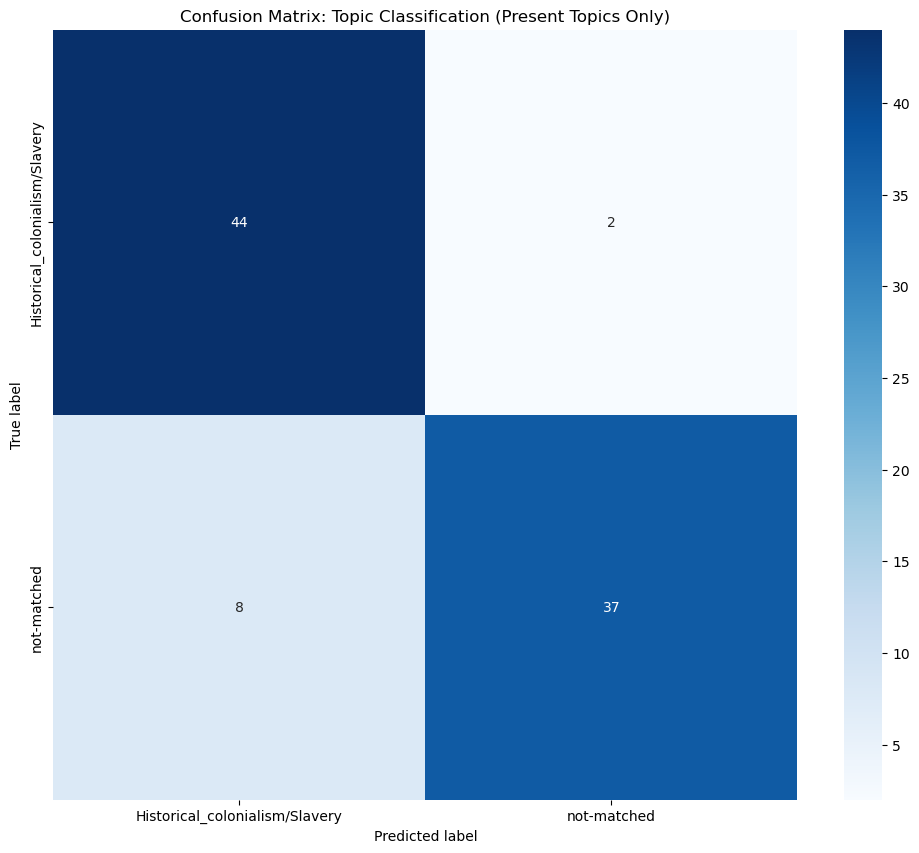

In [54]:
import os
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

# --- 1. Prepare DataFrame and Encode Labels ---
# matched_df should have columns: 'sentence' and 'topic'
le = LabelEncoder()
matched_df['label'] = le.fit_transform(matched_df['topic'])

# Split your data (replace with your split method)
# Example:
# train_df = matched_df.sample(frac=0.8, random_state=42)
# val_df = matched_df.drop(train_df.index)

# (If you already have train_df/val_df with the correct 'label' column, continue)

# Build label2topic and topic2label for reference
label2topic = dict(zip(le.transform(le.classes_), le.classes_))
topic2label = dict(zip(le.classes_, le.transform(le.classes_)))
print("label2topic:", label2topic)

with open('slavery-label2topic.pickle', 'wb') as fp:
    pickle.dump(label2topic, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('slavery-topic2label.pickle', 'wb') as fp:
    pickle.dump(topic2label, fp, protocol=pickle.HIGHEST_PROTOCOL)



# --- 2. Convert to HuggingFace Datasets ---
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# --- 3. Tokenization ---
MODEL_NAME = "GroNLP/bert-base-dutch-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# --- 4. Model Setup ---
num_labels = len(label2topic)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

# --- 5. TrainingArguments ---
os.environ["WANDB_DISABLED"] = "true"
training_args = TrainingArguments(
    output_dir="./bertje_slavery",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# --- 6. Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# --- 7. Training ---
trainer.train()

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# After prediction:
eval_results = trainer.predict(val_dataset)
pred_labels = np.argmax(eval_results.predictions, axis=1)
true_labels = eval_results.label_ids

# --- Safe label/name selection for reporting ---
# Only include labels actually present in y_true or y_pred, and that exist in label2topic
unique_labels = sorted(set(np.unique(true_labels)).union(np.unique(pred_labels)))
all_labels = [l for l in unique_labels if l in label2topic]
all_names = [label2topic[l] for l in all_labels]

# Per-class report (always aligned to what's present)
print(classification_report(
    true_labels,
    pred_labels,
    labels=all_labels,
    target_names=all_names,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_names, yticklabels=all_names, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix: Topic Classification (Present Topics Only)")
plt.show()

# -- Save your full mappings for future use --
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
with open('slavery-label2topic.pickle', 'wb') as fp:
    pickle.dump(label2topic, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('slavery-topic2label.pickle', 'wb') as fp:
    pickle.dump(topic2label, fp, protocol=pickle.HIGHEST_PROTOCOL)